In [50]:
import gymnasium as gym
from bettermdptools.algorithms.planner import Planner
from bettermdptools.utils.plots import Plots
from gymnasium.envs.toy_text.frozen_lake import generate_random_map
from bettermdptools.utils.test_env import TestEnv
from mountainCartWrapper2 import MountainCartWrapper
from tqdm import tqdm
import seaborn as sns

import pickle
import numpy as np
import pandas as pd
import random

from utils import *

np.random.seed(42)
random.seed(42)

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
size = 100
map_size = (size, size)
env = gym.make('MountainCar-v0', render_mode="rgb_array", max_episode_steps=1000)
env = MountainCartWrapper(env, discrete_step=size)

In [52]:
V, V_track, pi, pi_track, timings  = Planner(env.P).value_iteration(gamma=0.999, theta=1e-12, n_iters=100000)
# V, V_track, pi, pi_track, timings, total_updates  = Planner(env.P).policy_iteration(gamma=0.99, theta=1e-8, n_iters=100000)

Total Q updates: 4050000
runtime = 2.74 seconds


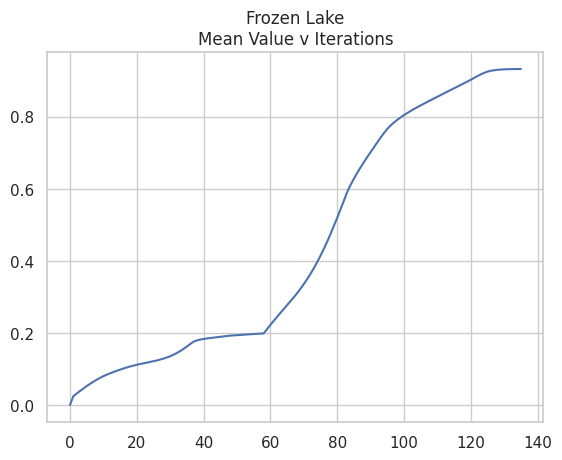

In [53]:
# Clip trailing zeros in case convergence is reached before max iterations
# This is likely when setting the n_iters parameter
max_value_per_iter = np.trim_zeros(np.mean(V_track, axis=1), 'b')
Plots.v_iters_plot(max_value_per_iter, "Frozen Lake\nMean Value v Iterations")

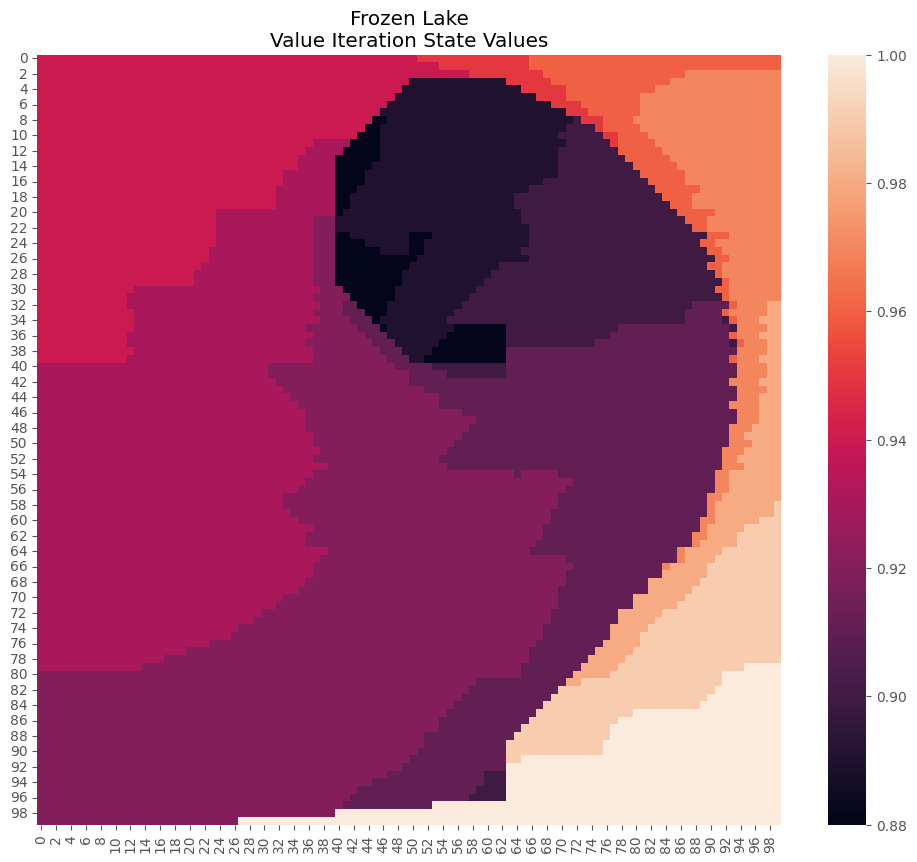

In [26]:
Plots.values_heat_map(V, "Frozen Lake\nValue Iteration State Values", map_size, annot=False, figsize=(12,10))

In [6]:
def one_shot_eval(env, pi):
    episode_rewards, run_length, _ = TestEnv.test_env(env=env, n_iters=100, pi=pi, convert_state_obs=lambda state : env.convert_2d_to_1d(state))
    episode_rewards = np.array(episode_rewards)
    print(f"Mean reward: {np.mean(episode_rewards)}")
    
one_shot_eval(env, pi)

Mean reward: -162.27


In [9]:
%matplotlib inline
plt.style.use('ggplot')
is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

Score:  168


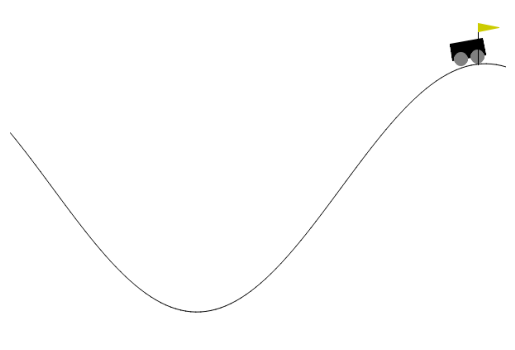

In [10]:
#  Let's see how the agent performs in the environment by running a single iteration of 1000 steps
# and rendering the environment at each step
env.reset()
state = env.state
# print(state)

img = plt.imshow(env.render())
state = env.transform_obs(state)

for t in range(300):
    state = env.convert_2d_to_1d(state)
    action = pi[state]
    img.set_data(env.render())
    # add the action on the image
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    state, reward, done, b, c = env.step(action)
    test = env._inverse_transform_obs(state)
    if done:
        print('Score: ', t+1)
        break
        
env.close()

In [44]:
size = 100
env = gym.make('MountainCar-v0', render_mode="rgb_array", max_episode_steps=1000)
env = MountainCartWrapper(env, discrete_step=size)

In [45]:
V, V_track, pi, pi_track, timings  = Planner(env.P).policy_iteration(gamma=0.999, theta=1e-9, n_iters=10000)

Total Q updates: 13810000
runtime = 8.61 seconds


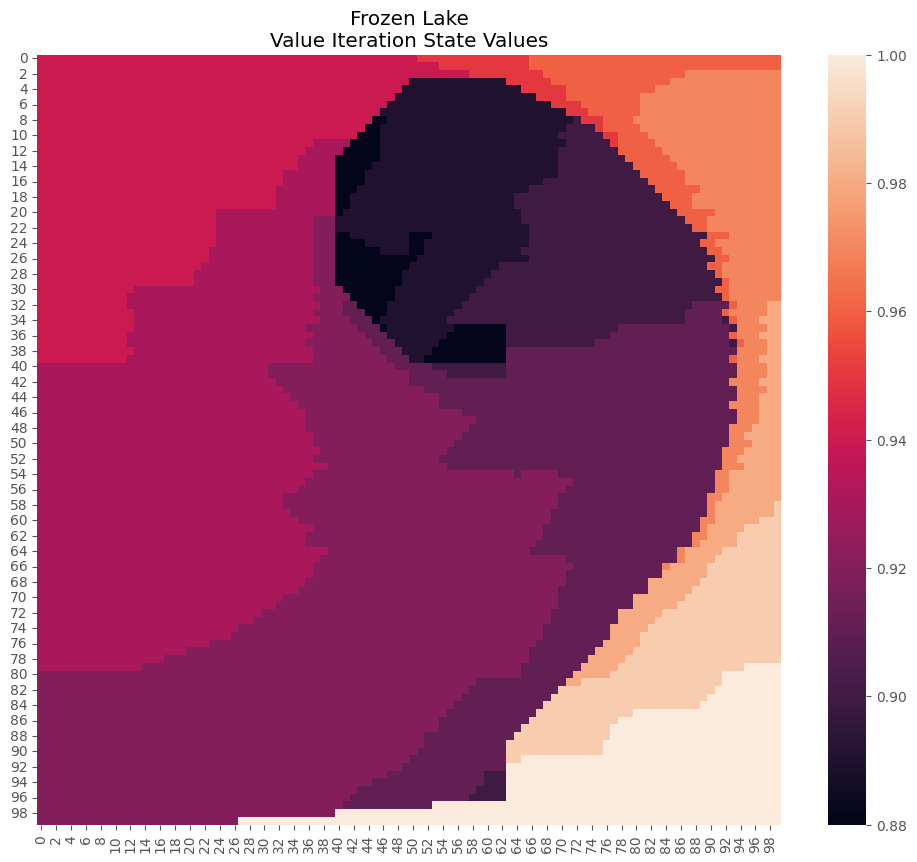

In [46]:
Plots.values_heat_map(V, "Frozen Lake\nValue Iteration State Values", (size,size), annot=False, figsize=(12,10))

In [47]:
one_shot_eval(env, pi)

/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Mean reward: -1000.0


Number of policy changes: 7342


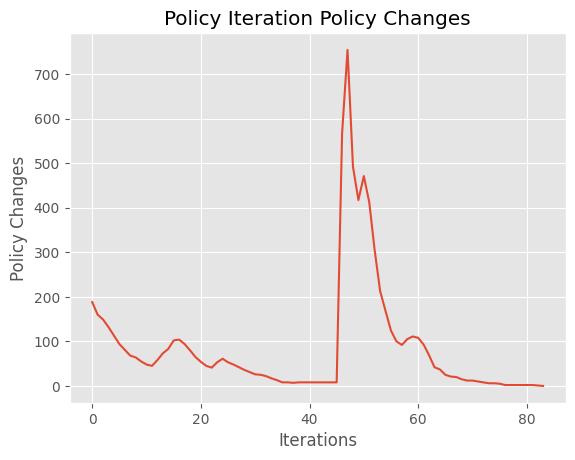

In [48]:
def policies_changes_plot(pi_tracks, title, upper_bound=100):

    # find the longest pi_track
    max_len = max([len(pi_track) for pi_track in pi_tracks])
    # pad the pi_tracks with the last policy to have the same length
    for pi_track in pi_tracks:
        while len(pi_track) < max_len:
            pi_track.append(pi_track[-1])


    for pi_track in pi_tracks:
        changes = []
        for i in range(1, upper_bound+1):
            if len(pi_track) == i:
                break
            # count the number of different values between the two policies betweeen i and i-1 (they are dictionaries)
            n_changes = sum([1 for key in pi_track[i] if pi_track[i][key] != pi_track[i-1][key]])

            changes.append(n_changes)
        plt.plot(changes)
        print(f"Number of policy changes: {np.sum(changes)}")
    if upper_bound < 10:
        plt.xticks(range(upper_bound))    
    plt.xlabel("Iterations")
    plt.ylabel("Policy Changes")
    plt.title(title)
    # plt.legend(["20x20","8x8", "4x4"])
    plt.show()

policies_changes_plot([pi_track], "Policy Iteration Policy Changes", upper_bound=100)

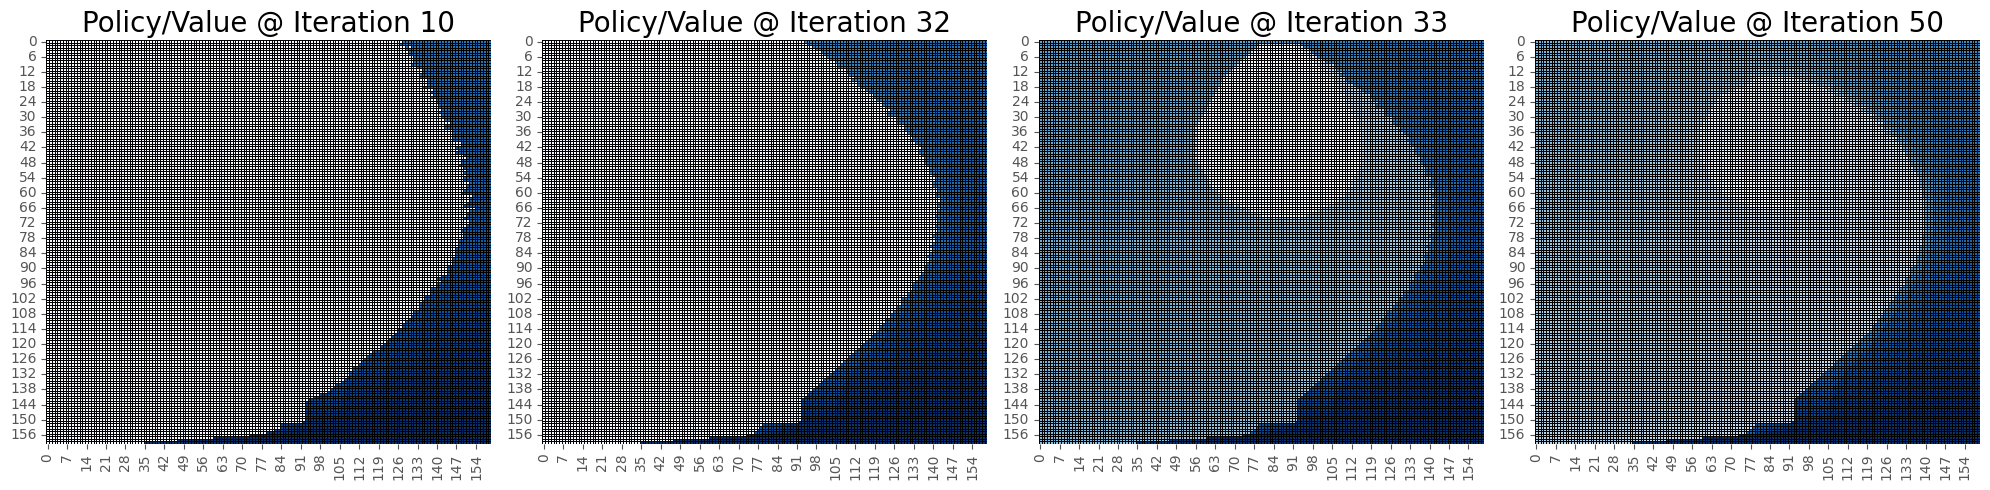

In [145]:
def plot_multiple_policies(V_track, pi_track,  indices = [5,10,25,50], map_size=(8,8), filename=None):
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    fl_actions = {0: "←", 1: "↓", 2: "→", 3: "↑"}
    fl_map_size=(10,10)

    for i, idx in enumerate(indices):
        val_max, policy_map = Plots.get_policy_map(pi_track[idx], V_track[idx], fl_actions, map_size)
        sns.heatmap(
            val_max,
            # annot=policy_map,
            annot=False,
            fmt="",
            cmap=sns.color_palette("Blues", as_cmap=True),
            linewidths=0.7,
            linecolor="black",
            # annot_kws={"fontsize": "xx-large", "fontweight": "bold", "color": "black", "style": "italic"},
            ax=axs[i],
            cbar = False
        )
        axs[i].set_title(f"Policy/Value @ Iteration {idx}", fontsize=20)

    if filename:
        plt.tight_layout()
        plt.savefig(f'figures/frozen_lake/{filename}.pdf', format='pdf', bbox_inches='tight')
    plt.show()

plot_multiple_policies(V_track, pi_track, indices=[10,32,33,50], map_size=(160,160), filename="frozen_lake_policy_iteration")

In [46]:
size = 25
env = gym.make('MountainCar-v0', render_mode="rgb_array", max_episode_steps=1000)
env = MountainCartWrapper(env, discrete_step=size)

In [47]:
Q_q, V_q, pi_q, Q_track_q, pi_track_q = RL(env).q_learning(
    nS=25*25,
    convert_state_obs= lambda state : env.convert_2d_to_1d(state),
    nA=3,
    gamma=.99,
    init_alpha=0.02,
    min_alpha=0.01,
    alpha_decay_ratio=1,
    init_epsilon=1.0,
    min_epsilon=0.1,
    epsilon_decay_ratio=0.9995,
    n_episodes=10000
)

  0%|          | 0/10000 [00:00<?, ?it/s]

/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/bettermdptools/algorithms/rl.py:174: UserWarning: Episode was truncated.  Bootstrapping 0 reward.
  warnings.warn("Episode was truncated.  Bootstrapping 0 reward.")


runtime = 124.75 seconds


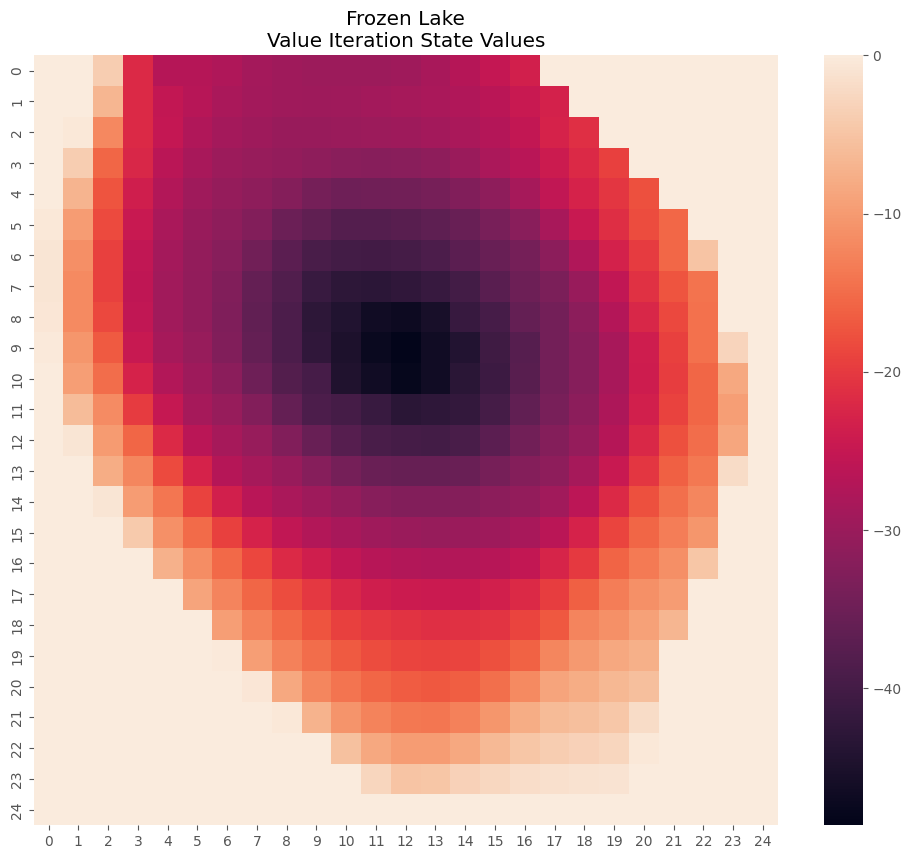

In [48]:
Plots.values_heat_map(V_q, "Frozen Lake\nValue Iteration State Values", (25,25), annot=False, figsize=(12,10))

In [49]:
one_shot_eval(env, pi_q)

Mean reward: -161.35


Score:  161


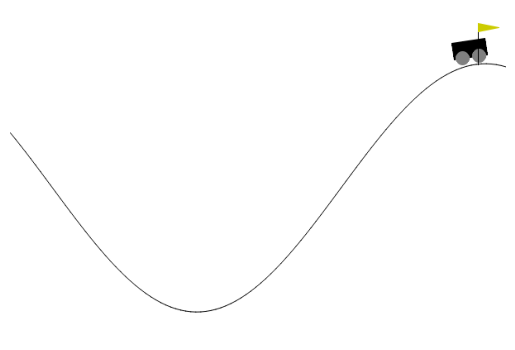

In [52]:
#  Let's see how the agent performs in the environment by running a single iteration of 1000 steps
# and rendering the environment at each step
env.reset()
state = env.state
# print(state)

img = plt.imshow(env.render())
state = env.transform_obs(state)

for t in range(1000):
    state = env.convert_2d_to_1d(state)
    action = pi_q[state]
    img.set_data(env.render())
    # add the action on the image
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    state, reward, done, b, c = env.step(action)
    if done:
        print('Score: ', t+1)
        break
        
env.close()